In [2]:
import os
import torch
import numpy as np
import pandas as pd
from GT import get_dataset
import matplotlib.pyplot as plt
from tsl.datasets import AirQuality
from tsl.datasets.mts_benchmarks import ExchangeBenchmark
from tsl.metrics.numpy import mae, mase_time, mape, mse

Dataset1 = 'Synthetic'
Dataset2 = 'ExchangeBenchmark'
Dataset3 = 'AirQuality'

datasets = {'Synthetic': {}, 'ExchangeBenchmark': {}, 'AirQuality': {}} # Initialize empty dictionaries for each dataset type.

dataset3_cols = AirQuality(impute_nans=True, small=True).dataframe().columns.droplevel('channels')
dataset2_cols = ExchangeBenchmark().dataframe().columns.droplevel('channels')
dataset1_cols = ['sin', 'cos', 'sincos', 'scos', 'csin', 'tan']

In [3]:
datasets[Dataset1]['Original'] = get_dataset('Synth', window=63)[0]
datasets[Dataset2]['Original'] = get_dataset(Dataset2, ExchangeBenchmark().dataframe()[:7560], 216)[0]
datasets[Dataset3]['Original'] = get_dataset(Dataset3, AirQuality(impute_nans=True, small=True).dataframe()[:8736], 168)[0]

Synth DATA
Original Dataset: 	156
Train Split: 		52 	(70%)
Validation Split: 	52 	(20%)
Test Split: 		52 	(10%)
ExchangeBenchmark DATA
Original Dataset: 	105
Train Split: 		35 	(70%)
Validation Split: 	35 	(20%)
Test Split: 		35 	(10%)
AirQuality DATA
Original Dataset: 	156
Train Split: 		52 	(70%)
Validation Split: 	52 	(20%)
Test Split: 		52 	(10%)


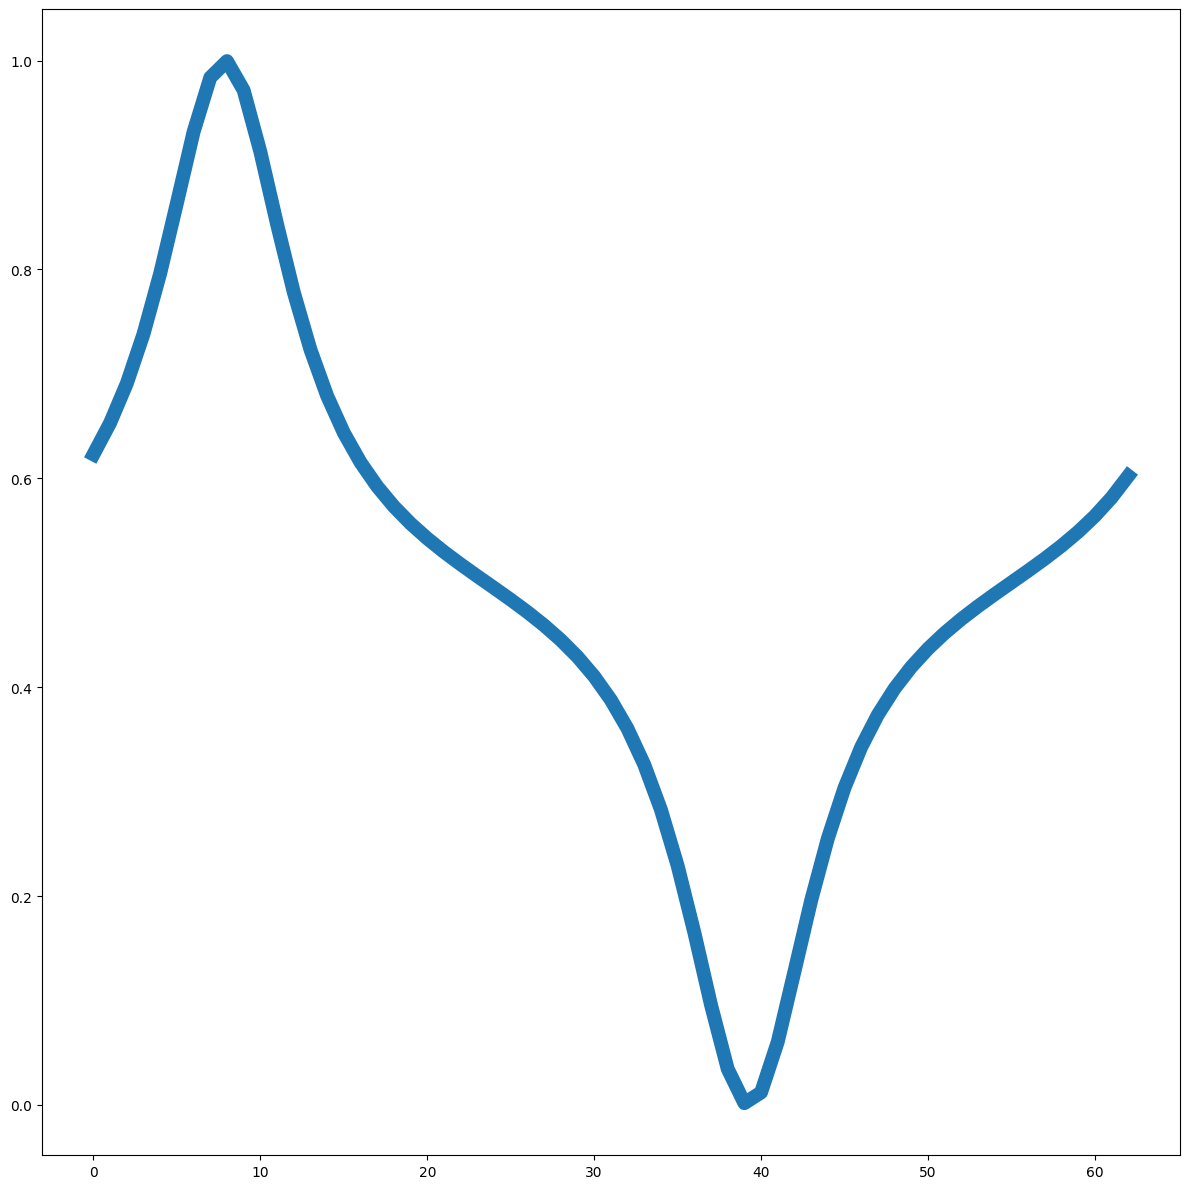

In [56]:
import colorsys
from ts2vg import NaturalVG
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate random time series (Brownian motion)
ts = datasets[Dataset1]['Original'][0, :, 5]

# 2. Build visibility graph
g = NaturalVG(directed='left_to_right').build(ts)
nxg = g.as_networkx()

# 3. Partition the graph into communities
communities = nx.algorithms.community.greedy_modularity_communities(nxg)

# 4. Make plots

COLORS = [
    "#4C72B0", "#DD8452", "#55A868", "#C44E52", "#8172B3",
    "#937860", "#DA8BC3", "#8C8C8C", "#CCB974", "#64B5CD",
]


def lighten_color(hex_color, factor=0.3):
    """Lightens the given color by a factor of 0-1 (0 = no change, 1 = white)."""
    # Convert hex to RGB
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    # Convert RGB to HLS
    h, l, s = colorsys.rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)
    # Lighten the color
    l = min(1, l + (1 - l) * factor)
    # Convert HLS back to RGB
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    # Convert back to hex
    return "#{:02x}{:02x}{:02x}".format(int(r * 255), int(g * 255), int(b * 255))


node_colors = ["#000000"] * len(ts)
for community_id, community_nodes in enumerate(communities):
    for node in community_nodes:
        node_colors[node] = COLORS[community_id % len(COLORS)]

fig, ax1 = plt.subplots(ncols=1, figsize=(12, 12))

graph_plot_options = {
    "with_labels": False,
    "node_size": 100,
    "node_color": [node_colors[n] for n in nxg.nodes],
}

ax1.plot(ts, linewidth=10)
# ax0.set_title("Time Series")

# nx.draw_networkx(nxg, ax=ax1, pos=g.node_positions(), edge_color=[(0, 0, 0, 0.15)], arrowsize=15, arrows=True, **graph_plot_options)
# # ax1.tick_params(bottom=True, labelbottom=True)
# ax1.plot(ts, c=(0, 0, 0, 0.15))
# ax1.set_title("Visibility Graph")
plt.tight_layout()
plt.savefig('TS.png', dpi=300, transparent=True)

# nx.draw_networkx(nxg, ax=ax2, pos=nx.kamada_kawai_layout(nxg), **graph_plot_options)
# ax2.set_title("Visibility Graph")

In [3]:
datasets[Dataset1]['Original']

array([[[0.49999755, 1.        , 0.85355309, 1.        , 1.        ,
         0.6229301 ],
        [0.5499145 , 0.99750208, 0.88708332, 0.99838987, 0.98916849,
         0.6531254 ],
        [0.5993327 , 0.99003329, 0.91674592, 0.99350154, 0.95721117,
         0.69091056],
        ...,
        [0.36028912, 0.98008514, 0.74068259, 0.98681965, 0.91563326,
         0.56392318],
        [0.40891585, 0.99163422, 0.78323325, 0.99455866, 0.9640073 ,
         0.58144842],
        [0.45845265, 0.99827105, 0.82295392, 0.99888687, 0.9924952 ,
         0.60226131]],

       [[0.50840454, 0.99992932, 0.85944773, 0.99995461, 0.99969251,
         0.62755911],
        [0.55827244, 0.99659246, 0.89235005, 0.99780045, 0.9852421 ,
         0.65889379],
        [0.60755807, 0.98829381, 0.92133213, 0.9923472 , 0.94986007,
         0.69815192],
        ...,
        [0.36838101, 0.98236631, 0.74801744, 0.98836897, 0.92506837,
         0.56668185],
        [0.41719506, 0.99309615, 0.79012126, 0.99551957, 0.970

In [39]:
dataset_path = './Datasets/PredictionDatasets/'

Order = ['Original', 'GTR', 'GTLSTM', 'GTM', 'GGTM', 'SGGTM', 'ASGGTM']

for dir in os.listdir(dataset_path):
    if os.path.isdir(f"{dataset_path}/{dir}"):   # If it's a valid folder, iterate through its contents (datasets).
        steps = datasets[dir]['Original'].shape[1]
        for file in os.listdir(f"{dataset_path}/{dir}"):   # Iterate over each file in the directory (each dataset)
            if not file.split('_')[0].endswith('Regressor'):
                data = np.loadtxt(dataset_path + dir + '/' + file , delimiter = ' ')   # Load the data from each .txt files into a numpy array (each dataset)
                datasets[dir][file.split('_')[0]] = data.reshape(data.shape[0]//steps, steps, data.shape[-1])
                # datasets[dir][file.split('_')[0]] = data.reshape(data.shape[0]//steps, steps, data.shape[-1])
                
        datasets[dir] = {key: datasets[dir][key] for key in Order if key in datasets[dir]}
        

def calculateVals(datasets: dict):
    ori = datasets.pop('Original')
    res = []
    for key, data in datasets.items():
        res.append({
                   'dataset': key,
                   'mape_score': mape(ori, data), 
                   'mae_score': mae(ori, data),
                   'mse_score': mse(ori, data),
                   'mase_time_score': mase_time(ori, data)
            }
        )
    return pd.DataFrame(res)


In [40]:
datasets[Dataset2]['Original'].shape

(35, 216, 8)

In [ ]:

plt.plot(datasets[Dataset3]['Original'][21][:, 1], label='Original')
# plt.plot(datasets[Dataset3]['ASGGTM'][21][:, 4], label='ASGGTM')
# plt.plot(datasets[Dataset2]['GTLSTM'][1][:, 1], label='LSTM')
# plt.plot(datasets[Dataset3]['GTM'][21][:, 4], label='MDN')
plt.plot(datasets[Dataset3]['GTR'][21][:, 4], label='RNN')
plt.legend()

In [33]:
calculateVals(datasets[Dataset1])

,dataset,mape_score,mae_score,mse_score,mase_time_score
0,GTR,0.697779,0.172041,0.042446,1.276029
1,GTLSTM,0.592032,0.257297,0.088881,8.631876
2,GTM,3.657324,0.275129,0.120946,0.680622
3,GGTM,0.399419,0.069180,0.012181,0.216132
4,ASGGTM,0.402440,0.029226,0.001610,0.084548


In [34]:
calculateVals(datasets[Dataset2])

,dataset,mape_score,mae_score,mse_score,mase_time_score
0,GTR,0.399015,0.113063,0.021910,1.296473
1,GTLSTM,0.433724,0.159322,0.038968,2.460625
2,GTM,1.123644,0.164760,0.045377,0.603457
3,GGTM,0.102431,0.019876,0.000769,0.107329
4,ASGGTM,0.048018,0.012316,0.000274,0.063704


In [35]:
calculateVals(datasets[Dataset3])

,dataset,mape_score,mae_score,mse_score,mase_time_score
0,GTR,1.684335,0.082362,0.013720,1.637796
1,GTLSTM,0.732006,0.099823,0.021268,2.956714
2,GTM,3.613848,0.096434,0.019485,0.860965
3,GGTM,4.731938,0.079681,0.016137,0.908514
4,SGGTM,2.445069,0.065564,0.012436,0.837300
5,ASGGTM,2.187775,0.059080,0.008748,0.749147
